In [84]:
import numpy as np
import scipy.stats as st
import pandas as pd
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split
import pymc3 as pm
import theano.tensor as tt
from theano import shared
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold,GroupKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from bartpy.sklearnmodel import SklearnModel
import sklearn.metrics as metrics
from IPython.display import display
import copy
import xgboost as xgb
from IPython.display import display,HTML,Markdown 

# Data manipulation
Importing data, splitting it to train and test (because of the imbalance between white and black water it would be better if we set a minimum of black points in the test and train)

In [163]:
otudf =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudf",index_col=0)
wwfdf = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdf",encoding="ISO-8859-1",index_col = "ID")
wwfdfmin = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdfmin",encoding="ISO-8859-1",index_col = "ID")
nmds20  = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/nmds20dim",index_col=0)
# Black water sites. There are 21 black water sites and 143 white water
blackindex = wwfdf[wwfdf["Water"] == "Black"].index
otudfCss =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfCss",index_col=0)
otudfMinCss =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfMinCss",index_col=0)
otudfLow = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfLow",index_col=0)
otudfCssLog = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfCssLog",index_col=0)

#Fish datasets
fishdf =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/fishdf",index_col=0)
fishdfCss =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/fishdfcss",index_col=0)
fishdfCssLog =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/fishdfcsslog",index_col=0)
wwfdffish  =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdffish",encoding="ISO-8859-1",index_col = "ID")

#Ordination imports
nmds20Css  = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/nmds20Css",index_col=0)
pcoaCss = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/pcoaCss",index_col=0)
pcoaOtu = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/pcoaOtu",index_col=0)

wwfdf.Water =(wwfdf.Water =="White")*1
wwfdfmin.Water =(wwfdfmin.Water =="White")*1
#Importing taxonomy
taxadf = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/taxadf",index_col=0)
# Splitting training and test data
np.random.seed(11235)
X_train,X_test,y_train,y_test = train_test_split(otudf,wwfdf.Water,test_size = 0.2)
np.random.seed(11235)
Xn_train,Xn_test,y_train,y_test = train_test_split(nmds20,wwfdf.Water,test_size = 0.2)

# Using Logistic Regression with Lasso
I am going to be trying both a frequentist and the bayesian approach. For the frequentist I will be using the sklearn package of python and for Bayesian I will use pymc3 to get the posterior distribution of the weights.

## Sklearn Frequentist Logistic regression

With saga solver and l1 penalty we get 94% accuracy on the test set
with liblinear it fluctuates between 85% and 90%, but it doesn't always converge

In [233]:
def log_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    try:
        penalty = args[0]["penalty"]
    except KeyError:
        penalty = "l1"
        print("You haven't specified a penalty, we will be using l1")
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    gsc = GridSearchCV(
        estimator=LogisticRegression(penalty=penalty,solver='liblinear',max_iter=1000,random_state=11235,fit_intercept=True),
        param_grid={
            'C': np.arange(0.001,20,1)
            #,'fit_intercept': (True)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, n_jobs=-1,refit = "accuracy",
        return_train_score = False
)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.coef_
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    # Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result,coefficients

In [33]:
logcv_best_params,logcv_grid = log_cv(X_train,y_train,None)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [280]:
crossfreq =cross_val_score(freq,otudf,y=wwfdf.Water,cv=10,n_jobs = -1)

In [118]:
# Similarity logistic run
similarity_log_df =runningsplittest(StratifiedKFold,log_cv,None,None,None)


TypeError: runningsplittest() missing 3 required positional arguments: 'index', 'xsetlist', and 'ysetlist'

In [108]:
# Similarity for PCoAs and PCoA css

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
#index = ["PCoA 99%","PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
#xsetlist = [pcoaOtu.iloc[:,0:55],pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
#ysetlist =[wwfdf,wwfdf,wwfdf,wwfdf]
xsetlist =[nmds20]
index=["nmds"]
ysetlist =[wwfdf]
dissim_log_df_nmds = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0 13]
 [ 0 19]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 0  0]
 [ 5 19]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 0 19]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits
(12,)
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
# disSimilarity for PCoAs
# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index = ["PCoA 99%","PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist = [pcoaOtu.iloc[:,0:55],pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf,wwfdf,wwfdf,wwfdf]
dissim_log_df_pcoas = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [85]:
# Dissimilarity logistic run
#dissndex = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
#xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
dissndex = ["PCoA","PCoA CSS"]
xsetlist = [pcoaOtu,pcoaCss]
ysetlist = [wwfdf,wwfdf]
dissimilarity_log_df =runningsplittest(GroupKFold,log_cv,dissndex,xsetlist,ysetlist)


0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 3 10]
 [ 0 19]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 3 23]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 0  0]
 [ 3 21]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 1  0]
 [ 2 17]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 3  2]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(12,)
[[ 0  0]
 [ 0 12]]
1
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 6  7]
 [ 1 18]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 1 25]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 0 19]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits
(12,)
[[ 0  0]
 [ 1 11]]


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [234]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
sim_logl1_fish = runningsplittest(StratifiedKFold,log_cv,index,xsetlist,ysetlist,penalty="l1")

0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 3 19]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 2  1]
 [ 1 21]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  4]
 [ 0 19]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 0 22]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 1 19]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 0 17]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 2  0]
 [ 0 18]]
1
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 2  1]
 [ 4 18]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 2  1]
 [ 1 21]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 4  1]
 [ 0 19]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 1 21]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 0  2]
 [ 0 20]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 1 16]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 2  0]
 [ 0 18]]
2
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 1 21]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 2  1]
 [ 1 21]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 4  1]
 [ 1 18]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 2  0]
 [ 0 22]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 0 20]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 4  0]
 [ 0 17]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits
(20,)
[[ 2  0]
 [ 0 18]]


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [237]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
dis_logl1_fish = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist,penalty="l1")

0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 3 10]
 [ 1 18]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [11 10]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 1 18]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(12,)
[[ 0  0]
 [ 1 11]]
1
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0 13]
 [ 0 19]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [13  8]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 6 13]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(12,)
[[0 0]
 [4 8]]
2
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 5  8]
 [ 1 18]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [ 4 17]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 1  0]
 [ 1 18]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 4  1]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits
(12,)
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [235]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
dis_logl2_fish = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist,penalty="l2")

0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 3 10]
 [ 2 17]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 2 17]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(12,)
[[ 0  0]
 [10  2]]
1
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 4  9]
 [ 1 18]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 1 25]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 2 17]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(12,)
[[0 0]
 [6 6]]
2
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 6  7]
 [ 1 18]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 1  0]
 [ 0 19]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 3  2]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits
(12,)
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [236]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
sim_logl2_fish = runningsplittest(StratifiedKFold,log_cv,index,xsetlist,ysetlist,penalty="l2")

0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 1 21]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 0 22]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 2  3]
 [ 0 19]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 1 21]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 2 18]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 0 17]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 2  0]
 [ 0 18]]
1
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 0 22]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 2  1]
 [ 0 22]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 2  3]
 [ 0 19]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 2  0]
 [ 0 22]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 2 18]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 0 17]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 2  0]
 [ 0 18]]
2
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 0 22]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 0 22]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 4  1]
 [ 0 19]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 2  0]
 [ 0 22]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 1 19]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 4  0]
 [ 0 17]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits
(20,)
[[ 2  0]
 [ 0 18]]


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [438]:
sim_log_df = pd.concat([similarity_log_df,sim_log_df_csslog_low])
dissim_log_df = pd.concat([dissimilarity_log_df,dissim_log_df_csslog_low])

### NMDS 20 dimensions as features

In [358]:
freq = LogisticRegression(penalty="l1",class_weight="balanced",multi_class="ovr",solver= "liblinear",max_iter=10000)
freq.fit(Xn_train,y_train)
freq.score(Xn_test,y_test)

0.9090909090909091

In [413]:
freq.coef_
freq.predict_proba(Xn_test)

array([[0.97560945, 0.02439055],
       [0.00477511, 0.99522489],
       [0.05475756, 0.94524244],
       [0.9015716 , 0.0984284 ],
       [0.00107508, 0.99892492],
       [0.06501476, 0.93498524],
       [0.33021778, 0.66978222],
       [0.00292009, 0.99707991],
       [0.13073513, 0.86926487],
       [0.84017414, 0.15982586],
       [0.00959059, 0.99040941],
       [0.2338178 , 0.7661822 ],
       [0.0203413 , 0.9796587 ],
       [0.06294322, 0.93705678],
       [0.05539342, 0.94460658],
       [0.88428876, 0.11571124],
       [0.61088869, 0.38911131],
       [0.17139272, 0.82860728],
       [0.00266087, 0.99733913],
       [0.10851913, 0.89148087],
       [0.09271962, 0.90728038],
       [0.35025824, 0.64974176],
       [0.31570521, 0.68429479],
       [0.1436603 , 0.8563397 ],
       [0.07236988, 0.92763012],
       [0.1378892 , 0.8621108 ],
       [0.04594739, 0.95405261],
       [0.97040154, 0.02959846],
       [0.96646219, 0.03353781],
       [0.21690098, 0.78309902],
       [0.

Both liblinear and saga produced 90% accuracy on the test set when using nmds as features

In [80]:
print(np.sum(y_test == "Black")/y_test.count())
np.sum(y_train == "Black")/(y_train.count())

0.12121212121212122


0.1297709923664122

In [90]:
 pd.DataFrame(data= freq.coef_.T).describe()
np.sum(freq.coef_ == 0)/np.size(freq.coef_)
# 32% of coefficients go to zero. The biggest weight has a magnitude of the order of 10e-4

0.3214814814814815

# Hypothesis testing of different splits
The aim is to test how well logistic regression and other classifiers perform under different train test splits 


In [210]:
def splithypothesis(*args,cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        CVfolds = cvgenerator(n_splits = number_of_folds)
        Kfolds = CVfolds.split(xtrain,y = set_for_kfold,groups=set_for_kfold)
#         for ind1,ind2 in Kfolds:
#             print(set_for_kfold.iloc[ind2])
        # Perform grid CV using Kfolds as folds.
        parameters,CVgrid,coef =model_cv(args[0],X=xtrain,y = ytrain,trainfolds=Kfolds)
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, CVgrid.predict(xtest))
        
        best_parameters.append(parameters)
        scoring_results.append( metrics.accuracy_score(ytest, CVgrid.predict(xtest)))
        coefficients.append(coef)
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [100]:
def splithypothesiscoin(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Water,groups=yset.Water)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        p =ytrain.mean()
        conf_matrix =np.array([[(1-p)*(ytest==0).sum(),(p)*(ytest==0).sum()],[(1-p)*(ytest==1).sum(),(p)*(ytest==1).sum()]])
        
        scoring_results.append( (conf_matrix[0,0]+conf_matrix[1,1])/(conf_matrix.sum()))
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [206]:
def runningsplittest(foldgenerator,model_cv,index,xsetlist,ysetlist,**kwargs):
    """
    Input
    foldgenerator: Stratified or Group KFold
    model_cv: The model CV to use, log_cv or rfr_cv
    
    """
    dictr ={"Scores":[],"Parameters":[],"Coefficients":[],"Confusion":[]}
    if index ==None:
        index = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
        xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
        ysetlist =[wwfdf,wwfdf,wwfdfmin,wwfdf,wwfdf]
    for i,j in enumerate(index):
        print(i)
        # Running the hypothesis for all cases in the index
        scoring,best_parameters,coefficents,confusion =splithypothesis(kwargs,cvgenerator=foldgenerator,xset=xsetlist[i],model_cv=model_cv,
                                number_of_splits=7,number_of_folds=6,yset=ysetlist[i])

        dictr["Scores"]+=[scoring]
        dictr["Parameters"] += [best_parameters]
        dictr["Coefficients"] += [coefficents]
        dictr["Confusion"] += [confusion]
    dataf =pd.DataFrame(data = dictr,index=index)
    return(dataf)

In [8]:
index = ["Normal","min"]
ysetlist = [wwfdf,wwfdfmin]
xsetlist = [pcoaCss,otudfMinCss]
#dis_coin=runningsplittest(GroupKFold,None,index,xsetlist,ysetlist)
#sim_coin=runningsplittest(StratifiedKFold,None,index,xsetlist,ysetlist)
rand_coin=runningsplittest(StratifiedKFold,None,index,xsetlist,ysetlist)

0
0
[[ 0.38571429  2.61428571]
 [ 2.7        18.3       ]]
1
[[ 0.38571429  2.61428571]
 [ 2.7        18.3       ]]
2
[[ 0.38571429  2.61428571]
 [ 2.7        18.3       ]]
3
[[ 0.38297872  2.61702128]
 [ 2.55319149 17.44680851]]
4
[[ 0.38297872  2.61702128]
 [ 2.55319149 17.44680851]]
5
[[ 0.38297872  2.61702128]
 [ 2.55319149 17.44680851]]
6
[[ 0.38297872  2.61702128]
 [ 2.55319149 17.44680851]]
1
0
[[ 0.40298507  2.59701493]
 [ 2.68656716 17.31343284]]
1
[[ 0.40298507  2.59701493]
 [ 2.68656716 17.31343284]]
2
[[ 0.40298507  2.59701493]
 [ 2.68656716 17.31343284]]
3
[[ 0.4         2.6       ]
 [ 2.53333333 16.46666667]]
4
[[ 0.4         2.6       ]
 [ 2.53333333 16.46666667]]
5
[[ 0.4         2.6       ]
 [ 2.53333333 16.46666667]]
6
[[ 0.4         2.6       ]
 [ 2.53333333 16.46666667]]


## Running the Hypothesis

In [12]:
dissimilarityscore_otu_lr =[0.65625,
 1.0,
 0.9285714285714286,
 0.5833333333333334,
 0.9,
 0.75,
 0.8333333333333334]
hypothesisresults.write(str(similarityscore_otu_lr))

66

In [10]:
similarityscore_otu_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otu_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 out of 120 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   41.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.5min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.1min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


TypeError: write() argument must be str, not list

In [31]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
similarityscore_otuCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otuCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


81

In [81]:
similarityscore_pcoaCss_lr,best_par_pcoaCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=pcoaCss.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("similarityscore_pcoaCss_lr")
hypothesisresults.write(str(similarityscore_pcoaCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


81

In [82]:
similarityscore_pcoaOtu_lr,best_par_pcoaOtu_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=pcoaOtu.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("similarityscore_pcoaCss_lr")
hypothesisresults.write(str(similarityscore_pcoaCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


81

In [35]:
similarityscore_otuMinCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("similarityscore_otuMinCss_lr")
hypothesisresults.write(str(similarityscore_otuMinCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


67

In [31]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
dissimilarityscore_nmds_lr = splithypothesis(cvgenerator=GroupKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
dissimilarityscore_otuCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


71

In [37]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("dissimilarityscore_otuCss_lr")
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


71

In [88]:
dissimilarityscore_pcoaCss_lr,best_par_diss_pcoaCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=pcoaCss.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("dissimilarityscore_pcoaCss_lr")
hypothesisresults.write(str(dissimilarityscore_pcoaCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


70

In [89]:
dissimilarityscore_pcoaOtu_lr,best_par_diss_pcoaOtu_lr = splithypothesis(cvgenerator=GroupKFold,xset=pcoaOtu.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("dissimilarityscore_pcoaCss_lr")
hypothesisresults.write(str(dissimilarityscore_pcoaCss_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


70

In [ ]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuMinCss_lr))

In [16]:
dissimilarityscore_otu_lr =splithypothesis(cvgenerator=GroupKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otu_lr))

0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


1
Fitting 6 folds for each of 20 candidates, totalling 120 fits
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.5min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   56.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


85

In [79]:
# print("NMDS")
# print(np.array( similarityscore_nmds_lr).mean())
# print(np.array( similarityscore_nmds_lr).var())
print("OTU")
print(np.array( similarityscore_otu_lr).mean())
print(np.array( similarityscore_otu_lr).var())
print("OTU Css")
print(np.array( similarityscore_otuCss_lr).mean())
print(np.array( similarityscore_otuCss_lr).var())
print("OTU Min Css")
print(np.array( similarityscore_otuMinCss_lr).mean())
print(np.array( similarityscore_otuMinCss_lr).var())
print("PCoA Otu")
print(np.array( similarityscore_pcoaOtu_lr).mean())
print(np.array( similarityscore_pcoaOtu_lr).var())

print("PCoA Css")
print(np.array( similarityscore_pcoaCss_lr).mean())
print(np.array( similarityscore_pcoaCss_lr).var())

print("Diss OTU")
print(np.array( dissimilarityscore_otu_lr).mean())
print(np.array( dissimilarityscore_otu_lr).var())

print("Diss OTU Css")
print(np.array( dissimilarityscore_otuCss_lr).mean())
print(np.array( dissimilarityscore_otuCss_lr).var())
print("Diss OTU Min Css")
print(np.array( dissimilarityscore_otuMinCss_lr).mean())
print(np.array( dissimilarityscore_otuMinCss_lr).var())

print("Diss PCoA Otu")
print(np.array( dissimilarityscore_pcoaOtu_lr).mean())
print(np.array( dissimilarityscore_pcoaOtu_lr).var())


print("Diss PCoA Css")
print(np.array( dissimilarityscore_pcoaCss_lr).mean())
print(np.array( dissimilarityscore_pcoaCss_lr).var())


OTU
0.9819884877027735
0.0004394230871916457
OTU Css
0.9622820037105752
0.0013889034604115445
OTU Min Css
0.9675850340136055
0.001078756536628257
PCoA Otu
0.9638994338994339
0.0013093487265315447
PCoA Css
0.9622820037105752
0.0013889034604115445
Diss OTU
0.8073554421768707
0.019624501799018923
Diss OTU Css
0.8573554421768707
0.011274870279744553
Diss OTU Min Css
0.8468994587082144
0.013978662509255604
Diss PCoA Otu
0.8798469387755102
0.00996238546438984
Diss PCoA Css
0.8852891156462585
0.012710025336665279


## Bayesian logistic regression using pymc3

I cant get it to work with either nmds or otutable, there might be something wrong with the code or with the implementation.

In [3]:
class BaysianClassifier:
    def __init__(self,niterations,regularisation,sampler=pm.NUTS):
        self.niter = niterations
        self.reg = regularisation
        self.sampler = sampler
    
    def fit(self,X,y,intercept=True,sigma=1):
        self.bay = pm.Model()
        self.x_shared = shared(np.array(X))
        with self.bay:
            # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
            mu = 0#pm.Normal('mu', 0.0, sd=1)
            inter = tt.constant(0)
            lam = sigma#pm.HalfCauchy('sd', 1.0)
            if self.reg == "l1":
                beta = pm.Laplace("betas",mu,lam,shape = X.shape[1])
                if intercept == True:
                    inter =  pm.Laplace("intercept",mu,lam,shape = 1)
            if self.reg == "l2":
                beta = pm.Normal("betas",mu,lam,shape = np.array(X).shape[1])
                if intercept == True:
                    inter =  pm.Normal("intercept",mu,lam,shape = 1)
                
                
            y_hat = tt.dot(self.x_shared,beta)+ inter
            # Calculating the probability of water being white p(y=1|mu) so that we can get 
            # p(y|x,beta) ~ Binomial(y|mu)
            #mu =logit(y_hat)
            y_obs = pm.Bernoulli("Y_obs",logit_p=y_hat,observed = y)
            self.MAP = pm.find_MAP()
            self.trace = pm.sample(self.niter,random_seed=11235,step =self.sampler() )
            #start= {"beta":freq.coef_.T}bl
            
    def predict(self,X,samples=2000):
        self.x_shared.set_value(X)
        ppc = pm.sample_posterior_predictive(self.trace,model = self.bay,samples=samples)
        yone =(ppc["Y_obs"] ==1).sum(axis=0)
        yzero =(ppc["Y_obs"] ==0).sum(axis=0)
        prediction_prob =st.beta(yone,yzero).mean()
        prediction_prob[np.isnan(prediction_prob)] =1
        return(prediction_prob)

In [4]:
def bayesiantest(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        #set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        
        # Perform grid CV using Kfolds as folds.
        model_cv.fit(xtrain,ytrain)
        best_parameters.append(copy.deepcopy(model_cv.trace))
        modelrpediction = model_cv.predict(xtest)
        
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, (modelrpediction>0.5)*1)
        
        
        scoring_results.append( metrics.accuracy_score(ytest, (modelrpediction>0.5)*1))
        
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [78]:
def mletest(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        #set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        model_cv =LogisticRegression(fit_intercept=True,penalty="l1",C=1)
        # Perform grid CV using Kfolds as folds.
        model_cv.fit(xtrain,ytrain)
        coefficients.append(np.append(model_cv.coef_,model_cv.intercept_))
        modelrpediction = model_cv.predict(xtest)
        
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, (modelrpediction)*1)
        
        
        scoring_results.append( metrics.accuracy_score(ytest, (modelrpediction>0.5)*1))
        
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [79]:
logistcmodel = LogisticRegression(fit_intercept=True,penalty="l1",C=1)
nmds_logl1 = runningbayesian(StratifiedKFold,logistcmodel,index,xsetlist,ysetlist)

0
0
(26,)
[[ 2  1]
 [ 0 23]]
1
(26,)
[[ 2  1]
 [ 3 20]]
2
(25,)
[[ 2  3]
 [ 0 20]]
3
(24,)
[[ 0  2]
 [ 0 22]]
4
(22,)
[[ 0  2]
 [ 0 20]]
5
(21,)
[[ 3  1]
 [ 0 17]]
6
(20,)
[[ 2  0]
 [ 0 18]]


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logisti

In [89]:
nmdscoefficients= nmds_logl1.Coefficients[0][0]

In [5]:
def runningbayesian(foldgenerator,model_cv,index,xsetlist,ysetlist):
    """
    Input
    foldgenerator: Stratified or Group KFold
    model_cv: The model CV to use, log_cv or rfr_cv
    
    """
    dictr ={"Scores":[],"Parameters":[],"Coefficients":[],"Confusion":[]}
    if index ==None:
        index = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
        xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
        ysetlist =[wwfdf,wwfdf,wwfdfmin,wwfdf,wwfdf]
    for i,j in enumerate(index):
        print(i)
        # Running the hypothesis for all cases in the index
        scoring,best_parameters,coefficents,confusion =bayesiantest(cvgenerator=foldgenerator,xset=xsetlist[i],model_cv=model_cv,
                                number_of_splits=7,number_of_folds=6,yset=ysetlist[i])

        dictr["Scores"]+=[scoring]
        dictr["Parameters"] += [best_parameters]
        dictr["Coefficients"] += [coefficents]
        dictr["Confusion"] += [confusion]
    dataf =pd.DataFrame(data = dictr,index=index)
    return(dataf)

In [6]:
bclsfr = BaysianClassifier(8000,"l1")

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index =["nmds"] #["PCoA 99%"]#,"PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist =[nmds20]# [pcoaOtu.iloc[:,0:55]]#,pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf]#,wwfdf,wwfdf,wwfdf]
dissim_baysl1_8k = runningbayesian(GroupKFold,bclsfr,index,xsetlist,ysetlist)

0
0


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -43.076, ||grad|| = 3.5033: 100%|██████████| 190/190 [00:00<00:00, 1033.42it/s] 
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:04<00:00, 423.39it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automa

(32,)
[[ 0 13]
 [ 0 19]]
1


logp = -54.324, ||grad|| = 2.6445: 100%|██████████| 121/121 [00:00<00:00, 1159.60it/s] 
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:04<00:00, 426.59it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


(32,)
[[ 0  0]
 [ 0 32]]
2


logp = -47.965, ||grad|| = 3.3567: 100%|██████████| 157/157 [00:00<00:00, 905.39it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:04<00:00, 436.05it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


(28,)
[[ 0  2]
 [ 3 23]]
3


logp = -52.415, ||grad|| = 3.0238: 100%|██████████| 112/112 [00:00<00:00, 1128.66it/s] 
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:05<00:00, 395.64it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


(24,)
[[ 0  0]
 [ 5 19]]
4


logp = -52.013, ||grad|| = 4.0437: 100%|██████████| 216/216 [00:00<00:00, 1090.74it/s] 
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:04<00:00, 423.12it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


(20,)
[[ 1  0]
 [ 1 18]]
5


logp = -47.435, ||grad|| = 3.77: 100%|██████████| 273/273 [00:00<00:00, 968.00it/s]   
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:04<00:00, 456.56it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


(16,)
[[ 2  3]
 [ 0 11]]
6


logp = -55.214, ||grad|| = 2.5444: 100%|██████████| 131/131 [00:00<00:00, 1191.89it/s] 
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:04<00:00, 430.79it/s]


(12,)
[[ 0  0]
 [ 0 12]]


In [27]:
sim_baysl2.to_pickle("sim_baysl2")
dissim_baysl2.to_pickle("dissim_baysl2")

In [26]:
bclsfr = BaysianClassifier(4000,"l2")

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index =["nmds"] #["PCoA 99%"]#,"PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist =[nmds20]# [pcoaOtu.iloc[:,0:55]]#,pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf]#,wwfdf,wwfdf,wwfdf]
dissim_baysl2 = runningbayesian(GroupKFold,bclsfr,index,xsetlist,ysetlist)

0
0


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -46.217, ||grad|| = 0.0051: 100%|██████████| 16/16 [00:00<00:00, 1632.82it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:03<00:00, 579.74it/s]


(32,)
[[ 0 13]
 [ 0 19]]
1


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -56.228, ||grad|| = 0.005277: 100%|██████████| 16/16 [00:00<00:00, 1604.06it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:03<00:00, 617.91it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will autom

(32,)
[[ 0  0]
 [ 0 32]]
2


logp = -51.246, ||grad|| = 0.0024948: 100%|██████████| 15/15 [00:00<00:00, 1622.51it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:03<00:00, 612.65it/s]


(28,)
[[ 0  2]
 [ 3 23]]
3


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -56.901, ||grad|| = 0.004574: 100%|██████████| 16/16 [00:00<00:00, 1396.97it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:03<00:00, 616.25it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will autom

(24,)
[[ 0  0]
 [ 0 24]]
4


logp = -54.824, ||grad|| = 0.0045185: 100%|██████████| 15/15 [00:00<00:00, 1416.39it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:03<00:00, 621.88it/s]


(20,)
[[ 0  1]
 [ 0 19]]
5


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -51.899, ||grad|| = 0.0045255: 100%|██████████| 17/17 [00:00<00:00, 1687.13it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:03<00:00, 617.55it/s]
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will auto

(16,)
[[ 0  5]
 [ 0 11]]
6


logp = -57.16, ||grad|| = 0.010073: 100%|██████████| 15/15 [00:00<00:00, 1537.16it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
100%|██████████| 2000/2000 [00:03<00:00, 619.09it/s]


(12,)
[[ 0  0]
 [ 0 12]]


In [24]:
sim_baysl1 = pd.read_pickle("sim_baysl1")
dissim_baysl1_v2 = pd.read_pickle("dissim_baysl1")

FileNotFoundError: [Errno 2] No such file or directory: 'dissim_baysl1'

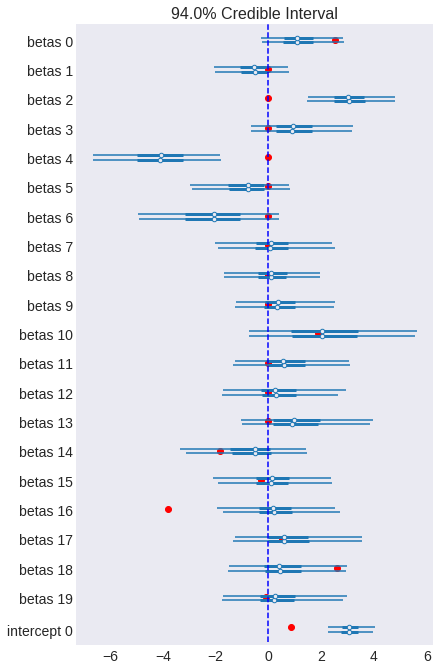

In [96]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#pm.plot_posterior(sim_baysl1.Parameters["nmds"][0])
pm.forestplot(sim_baysl1_8k.Parameters["nmds"][0])
plt.scatter(nmdscoefficients,np.linspace(0.5,59,21),c="red")
plt.vlines(x=0,ymin=-1,ymax=300,linestyles="dashed",colors="blue")
plt.savefig("forest_sim_l1.png",dpi=300)

In [12]:
%matplotlib inline 
pm.fores


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -52.982, ||grad|| = 2.454: 100%|██████████| 150/150 [00:00<00:00, 1543.56it/s]  
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:02<00:00, 410.21draws/s]


In [18]:
bclsfr.predict(Xn_test)

100%|██████████| 2000/2000 [00:03<00:00, 575.83it/s]


array([0.2055, 0.9855, 0.99  , 0.2965, 0.992 , 0.974 , 0.82  , 0.991 ,
       0.956 , 0.741 , 0.995 , 0.838 , 0.989 , 0.982 , 0.9525, 0.5925,
       0.7195, 0.9595, 0.996 , 0.982 , 0.97  , 0.76  , 0.8815, 0.936 ,
       0.9305, 0.966 , 0.959 , 0.146 , 0.1935, 0.9565, 0.9245, 0.974 ,
       0.9335])

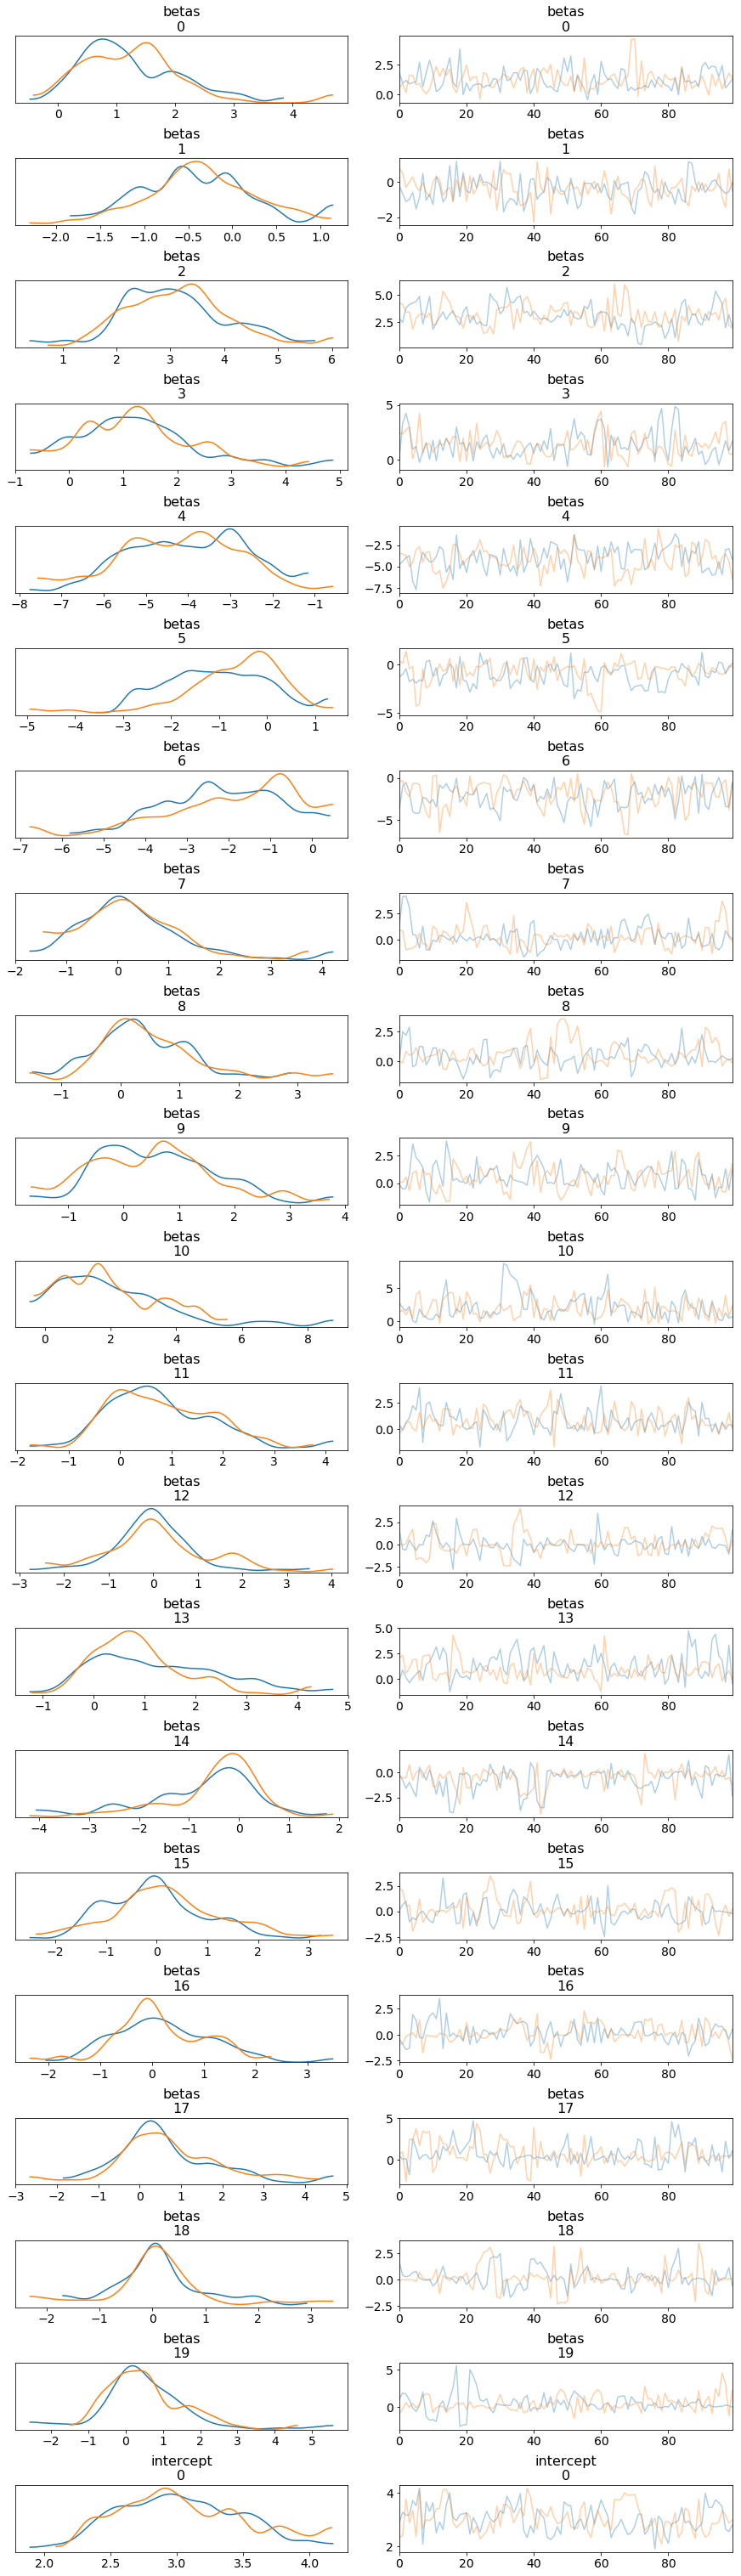

In [19]:
%matplotlib inline 

pm.traceplot(deepcopytrace);


In [187]:
baybetas =pm.find_MAP(model=bay)["beta"]


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -61.572, ||grad|| = 0.92708: 100%|██████████| 205/205 [00:00<00:00, 1236.96it/s] 


In [62]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
betas =df_trace.mean(0)[1:21]
#intercept = df_trace.mean(0)[-1]
#pm.find_MAP(model=bay)
#bay.Y_obs

In [17]:
def predict(X,betas,intercept):
    
    v = np.dot(X,betas) + intercept
    return(np.exp(v)/(1+np.exp(v)))

In [65]:
(predict(Xn_test,betas=betas,intercept=0) >= 0.5 )*1 ==y_test.bool

ID
2-S15D     True
3-S05d    False
3-S07d    False
2-S18C    False
1-S09B     True
2-S19A     True
3-S19b     True
1-S10C    False
2-S17A    False
3-S01a    False
1-S07D    False
1-S01C    False
1-S07C    False
1-S06A    False
1-S03B    False
2-S16D     True
3-S14e    False
3-S07a     True
3-S06d    False
3-S07b     True
3-S16c     True
1-S01A    False
1-S04D    False
3-S13d    False
3-S03a    False
1-S11D    False
1-S03D    False
2-S18D     True
2-S13C     True
2-S16A     True
3-S13b    False
3-S04b    False
2-S15F    False
Name: Water, dtype: bool

In [104]:
nobservations =150
covariates = np.random.randn(nobservations, 20)
covariates = np.hstack((np.ones((nobservations, 1)), covariates))

true_coefficients = 5 * np.random.rand(21)
true_logits = np.dot(covariates, true_coefficients) 
true_probs = 1.0 / (1.0 + np.exp(-true_logits))
observed_labels = (np.random.rand(nobservations) < true_probs).astype(np.int32)

In [8]:
covariates=Xn_train
covariates = np.hstack((np.ones((Xn_train.shape[0], 1)), covariates))
testset = np.hstack((np.ones((Xn_test.shape[0], 1)), Xn_test))
observed_labels = y_train.bool#(wwfdf.Water =="White")*1

In [10]:
testlog = LogisticRegression(penalty="l2",multi_class="ovr",solver= "saga",max_iter=100000,fit_intercept=False)
testlog.fit(covariates,observed_labels)
#plt.scatter(true_coefficients, testlog.coef_[0, :])
print(testlog.coef_)
#plt.show()
testlog.score(testset,y_test.bool)

[[ 2.12872457e+00  6.83251933e-01 -4.23743952e-01  1.91892137e+00
   9.39033023e-01 -1.89970326e+00 -6.29311823e-01 -1.07495353e+00
   3.09311744e-01  4.70658516e-01  6.24427100e-01  1.08507567e+00
   5.22415752e-01  2.11510231e-02  8.71823982e-01 -4.42129982e-01
  -1.55901587e-03  1.24958881e-01  5.69172029e-01  2.84463900e-01
   4.17924016e-01]]


1.0

In [15]:
nn = 20000
with pm.Model() as testmodel:
    # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
    beta = pm.Normal('beta', 0.0, sd=3.0, shape=20)
    intercept = pm.Normal("inter",0,sd=3,shape=1)
    likelihood = pm.Bernoulli('likelihood', logit_p= tt.dot(Xn_train,beta)+intercept , observed=observed_labels)
    tracetest =pm.sample(nn,step=pm.NUTS(),random_seed=11235)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [inter, beta]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:50<00:00, 819.76draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff89c03ee10>,
      dtype=object)

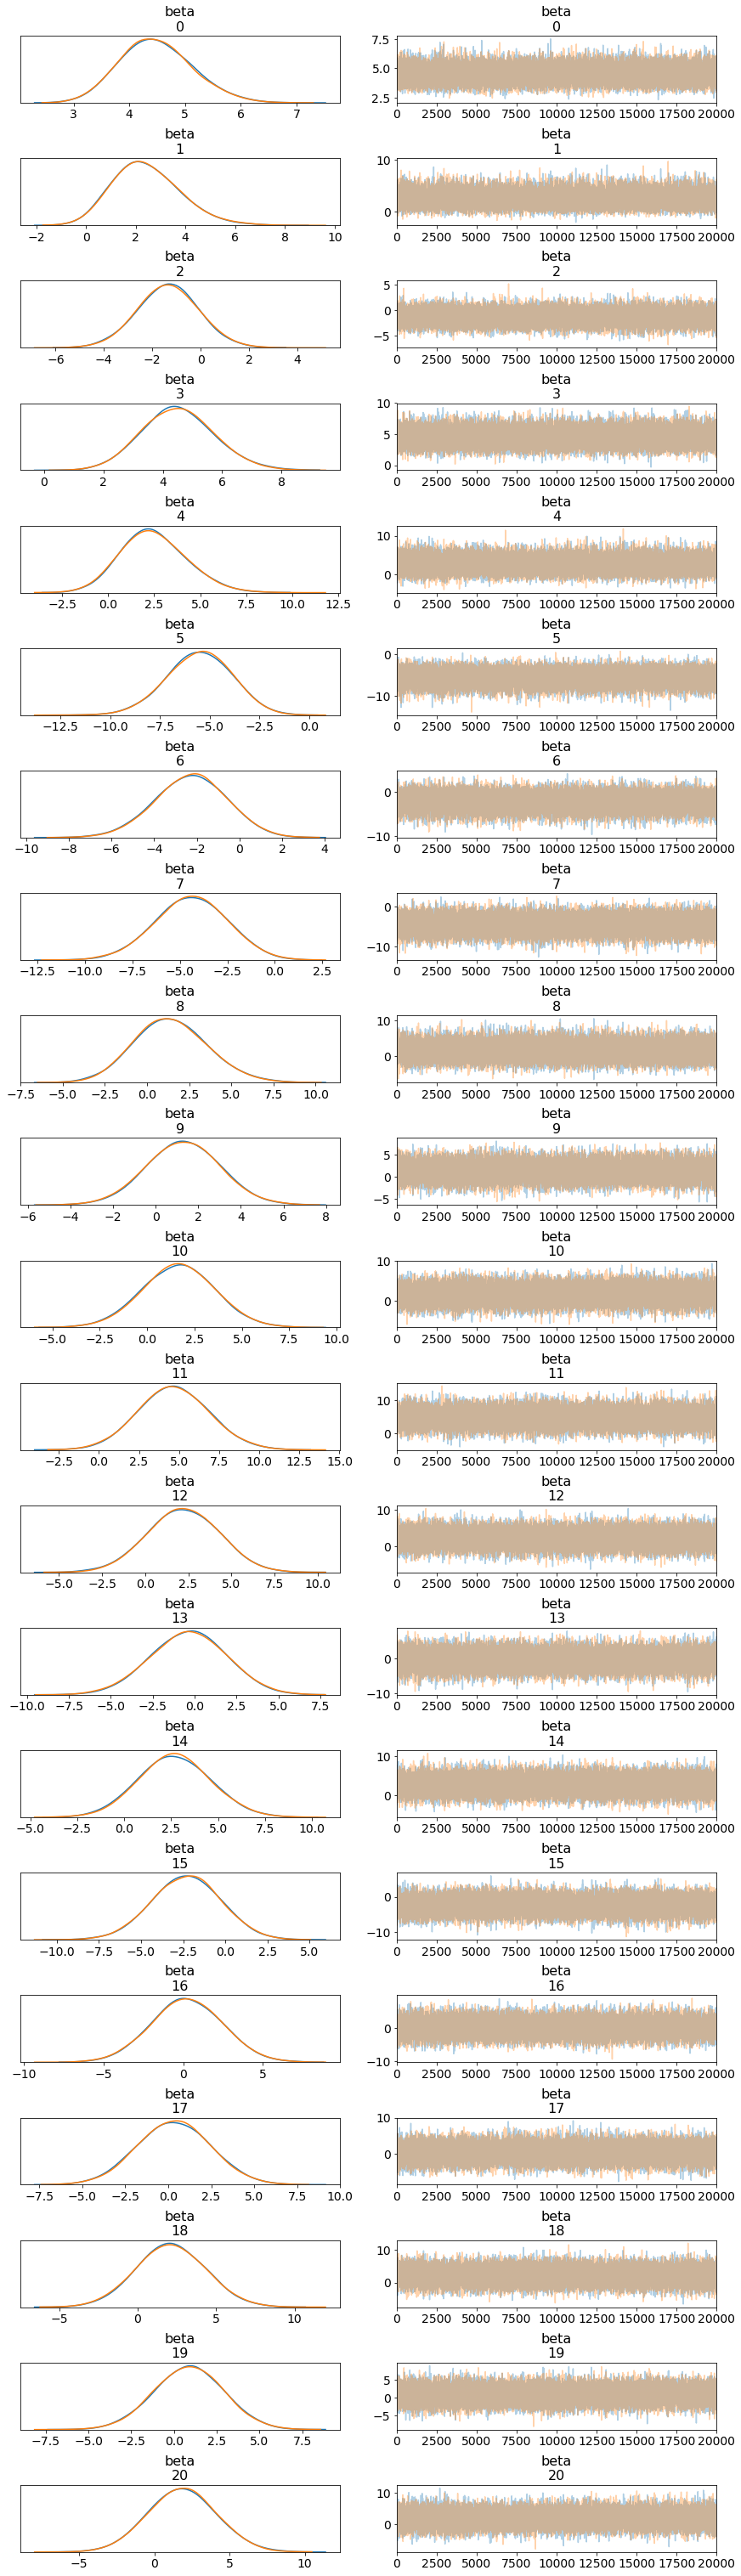

In [12]:
%matplotlib inline
pm.traceplot(tracetest)

In [28]:
maptest = (pm.find_MAP(model=testmodel))
maptest_beta = maptest["beta"]
maptest_inter = maptest["inter"]
#print(true_coefficients)
#plt.scatter(true_coefficients,maptest)

/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -60.543, ||grad|| = 0.00079067: 100%|██████████| 25/25 [00:00<00:00, 848.63it/s]  


In [141]:
# pred_probs =predict(testset,baybetas,0) >=0.5
# print((y_test.bool == pred_probs).mean())
pred_probs =predict(Xn_test,maptest_beta,maptest_inter) >=0.5
(y_test.bool == pred_probs).mean()

0.9696969696969697

# Random Forrest

In [216]:
def rfr_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(bootstrap=False),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (500, 1000,100,300),
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=2,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [29]:
bestpar,grid =rfr_cv(X_train,y_train,None)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   32.4s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  1.0min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [436]:
# Similarity for CSSLog and Lowcorrelation rfr
index = ["OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf]
sim_rfr_df_csslog_low = runningsplittest(StratifiedKFold,rfr_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   23.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   24.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   23.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   25.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   23.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   23.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   22.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   26.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   22.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   22.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   22.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [437]:
# disSimilarity for CSSLog and Lowcorrelation rfr
index = ["OTU CSS LOG","OTU LOW COR"]
xsetlist = [`otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf]
dissim_rfr_df_csslog_low = runningsplittest(GroupKFold,rfr_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   22.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   22.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   22.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   21.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [189]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
sim_rfr_fish = runningsplittest(StratifiedKFold,rfr_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(25,)
[[ 1  2]
 [ 0 22]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(25,)
[[ 0  3]
 [ 0 22]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 0  5]
 [ 0 19]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 1  1]
 [ 0 22]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(22,)
[[ 1  1]
 [ 1 19]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(21,)
[[ 3  1]
 [ 0 17]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(20,)
[[ 0  2]
 [ 0 18]]
1
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(25,)
[[ 2  1]
 [ 0 22]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(25,)
[[ 2  1]
 [ 0 22]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 3  2]
 [ 0 19]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 2  0]
 [ 0 22]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(22,)
[[ 1  1]
 [ 0 20]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(21,)
[[ 3  1]
 [ 0 17]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   34.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(20,)
[[ 0  2]
 [ 0 18]]
2
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(25,)
[[ 2  1]
 [ 0 22]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   34.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(25,)
[[ 2  1]
 [ 0 22]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   32.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 3  2]
 [ 0 19]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 2  0]
 [ 0 22]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(22,)
[[ 1  1]
 [ 0 20]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(21,)
[[ 3  1]
 [ 1 16]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   32.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(20,)
[[ 1  1]
 [ 0 18]]


In [188]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
dis_rfr_fish = runningsplittest(GroupKFold,rfr_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   39.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 0 13]
 [ 0 19]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   38.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   41.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   45.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   23.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   46.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(20,)
[[ 1  0]
 [ 0 19]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   36.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   32.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(12,)
[[ 0  0]
 [ 0 12]]
1
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   35.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(32,)
[[ 1 12]
 [ 0 19]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   35.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(20,)
[[ 0  1]
 [ 0 19]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(12,)
[[ 0  0]
 [ 0 12]]
2
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(32,)
[[ 0 13]
 [ 0 19]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   28.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(20,)
[[ 0  1]
 [ 0 19]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(12,)
[[ 0  0]
 [ 0 12]]


In [465]:
# concatenating
dissim_rfr_df = pd.concat([diffsimilarity_rfr_df,dissim_rfr_df_csslog_low])
sim_rfr_df = pd.concat([similarity_rfr_df,sim_rfr_df_csslog_low])

In [467]:
sim_rfr_df.to_csv(path_or_buf="sim_rfr_df_bootfalse")
dissim_rfr_df.to_csv(path_or_buf="dissim_rfr_df_bootfalse")
sim_log_df.to_csv(path_or_buf="sim_log_df")
dissim_log_df.to_csv(path_or_buf="disssim_log_df")


## Previous attempts of rfr

In [130]:
print("similarity RandomForestClassifier")
for j,i in enumerate( similarity_rfr_df["Scores"]):
#    print(i)
    print(diffsimilarity_rfr_df.index[j])
    print(np.array(i).mean())
    print(np.array(i).var())

similarity RandomForestClassifier
OTU
0.8775676704248133
0.002256161192429005
OTU CSS
0.9156781313924173
0.0016999700818616608
OTU MIN CSS
0.9062135151543455
0.0014879696255619673
PCoA
0.8720731649303077
0.0019371970587081986
PCoA CSS
0.8720731649303077
0.0019371970587081986


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


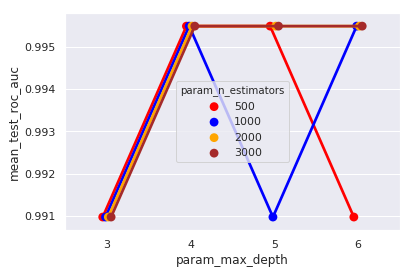

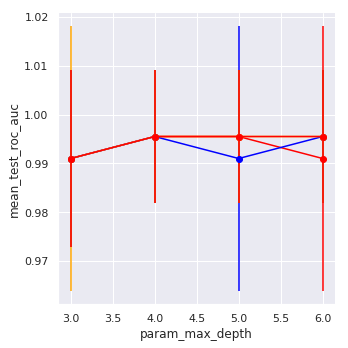

In [357]:
%matplotlib inline
sns.set()
gridpd =pd.DataFrame(grid.cv_results_)
#gridpd.columns
sns.pointplot(x="param_max_depth",y= "mean_test_roc_auc", palette=["red","blue","orange","brown"],hue="param_n_estimators",
             data=gridpd,dodge = True,ci ="sd")
#plt.ylim(0.987,1.001)
#plt.errorbar(data=gridpd,x = "param_max_depth",y= "mean_test_roc_auc",yerr="std_test_roc_auc")
g = sns.FacetGrid(gridpd, palette=["red","blue","orange"],hue="param_n_estimators"
, size=5)
g.map(plt.errorbar, "param_max_depth","mean_test_roc_auc", "std_test_roc_auc", marker="o")

In [213]:
rfr =RandomForestClassifier(max_depth=None, n_estimators=10000,random_state=True, verbose=True)
rfr.fit(X_train,y_train)
rfr.score(X_test,y_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.9s finished


0.9393939393939394

Random forest with 10000 trees, max depth set to None and random_state set to True produces an accuracy of 93%, which is equivalent to that of the logistic regression with the saga solver.

In [215]:
rfr.fit(Xn_train,y_train)
rfr.score(Xn_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.7s finished


0.9696969696969697

Using the nmds axis we get an accuracy of 96.7% (which is a single mistake!)

In [204]:
sum(rfr.predict(X_test) == y_test)/y_test.size

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


0.9090909090909091

In [274]:
crossrfr =cross_val_score(rfr,otudf,y=wwfdf.Water,cv=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurren

# XGBoost

In [54]:
def xgb_cv(X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(objective="binary:logistic",learning_rate=0.2),
        param_grid={
            'max_depth': range(1,3),
            'n_estimators': [500,600],
            "min_child_weight":range(1,3)
            #"reg_alpha":[0,0.3,0.7,1],
            #"reg_lambda":[0,0.3,0.7,1]
            
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [61]:
def xgb_rcv(X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(objective="binary:logistic",n_estimators=500),random_state = 42,
        param_distributions={
            'max_depth': range(2,4),
            "min_child_weight":range(1,3),
            "gamma": st.uniform(loc=0,scale=1),
            "reg_alpha":st.uniform(loc=0,scale =1),
            "reg_lambda":st.uniform(loc=0,scale=1)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False,n_iter = 200)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [62]:
index = ["OTU CSS LOG"]
xsetlist = [otudfCssLog]
ysetlist = [wwfdf]

dissim_xgb_rand =runningsplittest(GroupKFold,xgb_rcv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  7.3min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 2 11]
 [ 0 19]]
1
Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  8.6min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  8.6min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  8.9min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  9.0min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(20,)
[[ 1  0]
 [ 0 19]]
5
Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  8.8min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  9.4min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(12,)
[[ 0  0]
 [ 0 12]]


In [55]:
# index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
index = ["OTU CSS LOG"]
xsetlist = [otudfCssLog]
ysetlist = [wwfdf]

dissim_xgb_grid =runningsplittest(GroupKFold,xgb_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   12.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 2 11]
 [ 0 19]]
1
Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   12.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   13.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   13.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(24,)
[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   13.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(20,)
[[ 1  0]
 [ 0 19]]
5
Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   14.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(16,)
[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   17.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(12,)
[[ 0  0]
 [ 0 12]]


# KNN

In [213]:
def knn_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    print(args)
    knnmetric = args[0]["metric"]
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=KNeighborsClassifier(metric=knnmetric),
        param_grid={
        "n_neighbors": range(1,30),
       #,"braycurtis"],
            "weights":["uniform","distance"],
            "p": range(1,6)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    

    return (best_params,grid_result,None)

In [165]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

dis_knn_min_grid_fish =runningsplittest(GroupKFold,knn_cv,index,xsetlist,ysetlist,metric="minkowski")

0
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   16.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0 13]
 [ 0 19]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   22.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 2 24]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 0 19]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   22.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   22.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(12,)
[[ 0  0]
 [ 1 11]]
1
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0 13]
 [ 0 19]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   18.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 0  2]
 [ 7 19]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 0  1]
 [ 0 19]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   22.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(12,)
[[ 0  0]
 [ 0 12]]
2
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   18.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 6  7]
 [ 1 18]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   18.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(28,)
[[ 2  0]
 [ 6 20]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 0  0]
 [ 0 21]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 638 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 1  0]
 [ 8 11]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   23.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(16,)
[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    6.8s


(12,)
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   23.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [166]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_min_grid_fish =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist,knnmetric="minkowski")

0
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   18.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 1  2]
 [ 1 21]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 723 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 2  1]
 [ 0 22]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 4  1]
 [ 0 19]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   19.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 0  2]
 [ 0 22]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 1 19]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 1 16]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 2  0]
 [ 1 17]]
1
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 1  2]
 [ 0 22]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   19.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 0 22]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 3  2]
 [ 0 19]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   19.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 0 22]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 0 20]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 1 16]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 1  1]
 [ 0 18]]
2
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  0]
 [ 1 21]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 2  1]
 [ 0 22]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   20.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 4  1]
 [ 0 19]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 0 22]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   22.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 2  0]
 [ 1 19]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 1 16]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    6.1s


(20,)
[[ 2  0]
 [ 0 18]]


[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   21.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [207]:
def test(a,b,**kwarg):
    test2(kwarg,w=a)
def test2(*args,w):
    print(w,args[0])


In [209]:
test(a=1,b= 4,metric=5)

1 {'metric': 5}


In [ ]:
index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_min_grid =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist)

In [102]:
index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_bray_grid =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    9.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 2  1]
 [ 1 22]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 1  2]
 [ 0 23]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 4  1]
 [ 0 20]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 0 22]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 0  2]
 [ 0 20]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 0 17]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 1  1]
 [ 0 18]]
1
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 3  0]
 [ 1 22]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 3  0]
 [ 0 23]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  2]
 [ 0 20]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 0  2]
 [ 0 22]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 1  1]
 [ 0 20]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 1 16]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 1  1]
 [ 0 18]]
2
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 3  0]
 [ 0 23]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 3  0]
 [ 0 23]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 3  2]
 [ 0 20]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 0 22]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 1  1]
 [ 0 20]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 1 16]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(20,)
[[ 2  0]
 [ 0 18]]
3
0
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    6.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 2  1]
 [ 0 23]]
1
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    6.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(26,)
[[ 1  2]
 [ 0 23]]
2
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    6.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(25,)
[[ 4  1]
 [ 0 20]]
3
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    6.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(24,)
[[ 1  1]
 [ 0 22]]
4
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(22,)
[[ 0  2]
 [ 0 20]]
5
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    6.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(21,)
[[ 3  1]
 [ 0 17]]
6
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.5s


(20,)
[[ 1  1]
 [ 0 18]]


[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    6.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [69]:
dataset =dissim_knn_min_grid
print(dataset.Confusion)
print("\n")
print(dataset.Parameters[0])

OTU CSS LOG    [[11.0, 10.0], [4.0, 139.0]]
Name: Confusion, dtype: object


[{'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}, {'metric': 'minkowski', 'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}, {'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}, {'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}, {'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}, {'metric': 'minkowski', 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}, {'metric': 'minkowski', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}]


,Scores,Parameters,Coefficients,Confusion
OTU CSS LOG,"[0.75, 1.0, 0.9642857142857143, 1.0, 0.9, 0.81...","[{'metric': 'minkowski', 'n_neighbors': 1, 'p'...","[None, None, None, None, None, None, None]","[[11.0, 10.0], [4.0, 139.0]]"


In [103]:
sim_knn_bray_grid.to_pickle("sim_knn_bray_grid")
#sim_knn_min_grid.to_pickle("sim_knn_min_grid")

# BART

In [10]:
 pctrain,pctest,ytrain,ytest= train_test_split(pcoaOtu,wwfdf.Water,test_size = 0.2)
ytrain =(ytrain =="White")*1
ytest =(ytest =="White")*1

In [14]:
model = SklearnModel() # Use default parameters
model.fit(pctrain, ytrain) # Fit the model
#predictions = model.predict() # Make predictions on the train set
#out_of_sample_predictions = model.predict(X_test) # Make predictions on new data

UnboundLocalError: local variable 'mutation' referenced before assignment

# Opening dataframes

In [108]:
dissim_log_df =pd.read_pickle("dis_log")
dissim_rfr_df = pd.read_pickle("dis_rfr")
sim_log_df = pd.read_pickle("sim_log")
sim_rfr_df= pd.read_pickle("sim_rf")
rand_rfr_df = pd.read_pickle("rand_rfr")
rand_log_df = pd.read_pickle("rand_log")
sim_logl2_df =pd.read_pickle("sim_logl2_df")
dissim_logl2_df =pd.read_pickle("dissim_logl2_df")
dissim_knn_bray_grid = pd.read_pickle("dissim_knn_bray_grid")
dissim_knn_min_grid = pd.read_pickle("dissim_knn_min_grid")
sim_knn_min_grid = pd.read_pickle("sim_knn_min_grid")
sim_knn_bray_grid = pd.read_pickle("sim_knn_bray_grid")

In [7]:
dissim_baysl2 = pd.read_pickle("dissim_baysl2")

In [82]:
def printoutdataframe(dataframe):
    for j,i in enumerate(dataframe.Confusion):
        print(dataframe.index[j])
        print(i)
        acc = (i[0,0]+i[1,1])/i.sum()
        print(round(acc,4))

In [198]:
def zero_params(x):
    zeroes =[]
    for i in x:
        zeroes.append((i == 0).sum()/i.shape[1] )
    zeroes = np.array(zeroes).mean()
    return(zeroes)
dataframe = dissim_log_df
dataframe.Coefficients.apply(lambda x:zero_params(x))
    

OTU             0.884444
OTU CSS         0.917460
OTU MIN CSS     0.910688
PCoA            0.907792
PCoA CSS        0.883355
OTU CSS LOG     0.955767
OTU LOW COR     0.853398
PCoA 99%        0.812987
PCoA 90%        0.739496
PCoA CSS 99%    0.772959
PCoA CSS 90%    0.710204
NMDS            0.357143
Name: Coefficients, dtype: float64

In [199]:
index = ["OTU","OTU CSS","OTU CSS LOG"]

acv_coef =[]
for k in range(7):
    first_coef =[]
    for i in dissim_log_df.Coefficients[index]:
        #print(i)
        first_coef.append((i[k]==0.0)*1)
    commonz=[]  
    for j in range(first_coef[0].shape[1]):

        commonz.append(np.all(first_coef[0][0,j] == first_coef[1][0,j]==first_coef[2][0,j] == 0))
    acv_coef.append( np.array(commonz).mean())
np.array(acv_coef).mean()


0.03047619047619048

In [8]:
dataframe = dissim_baysl2

for j,i in enumerate(dataframe.Confusion):
    print(dataframe.index[j])
    print(i)
    acc = (i[0,0]+i[1,1])/i.sum()
    print(round(acc,4))

nmds
[[  0.  21.]
 [  3. 140.]]
0.8537


## LR

In [241]:
display(Markdown("### LR DIS"))
printoutdataframe( dis_logl2_fish)

### LR DIS

Fish
[[  4.  17.]
 [ 14. 126.]]
0.8075
Fish CSS
[[  5.  16.]
 [ 10. 130.]]
0.8385
Fish CSS LOG
[[ 10.  11.]
 [  1. 139.]]
0.9255


In [239]:
display(Markdown("### LR SIM "))
printoutdataframe( sim_logl2_fish)

### LR SIM 

Fish
[[ 16.   5.]
 [  4. 136.]]
0.9441
Fish CSS
[[ 16.   5.]
 [  2. 138.]]
0.9565
Fish CSS LOG
[[ 20.   1.]
 [  1. 139.]]
0.9876


## RFR

In [190]:
display(Markdown("### RFR DIS"))
printoutdataframe( dis_rfr_fish)

### RFR DIS

Fish
[[  1.  20.]
 [  0. 140.]]
0.8758
Fish CSS
[[  1.  20.]
 [  0. 140.]]
0.8758
Fish CSS LOG
[[  0.  21.]
 [  0. 140.]]
0.8696


In [191]:
display(Markdown("### RFR SIM"))
printoutdataframe( sim_rfr_fish)

### RFR SIM

Fish
[[  6.  15.]
 [  1. 139.]]
0.9006
Fish CSS
[[ 13.   8.]
 [  0. 140.]]
0.9503
Fish CSS LOG
[[ 14.   7.]
 [  1. 139.]]
0.9503


## KNN

In [242]:
display(Markdown("### KNN minkowski DIS"))
printoutdataframe( dis_knn_min_grid_fish)

### KNN minkowski DIS

Fish
[[  0.  21.]
 [  3. 137.]]
0.8509
Fish CSS
[[  0.  21.]
 [  7. 133.]]
0.8261
Fish CSS LOG
[[ 10.  11.]
 [ 15. 125.]]
0.8385


In [193]:
display(Markdown("### KNN minkowski SIM"))
printoutdataframe( sim_knn_min_grid_fish)

### KNN minkowski SIM

Fish
[[ 14.   7.]
 [  4. 136.]]
0.9317
Fish CSS
[[ 14.   7.]
 [  1. 139.]]
0.9503
Fish CSS LOG
[[ 17.   4.]
 [  3. 137.]]
0.9565


In [106]:
display(Markdown("### KNN braycurtis DIS"))
printoutdataframe( dissim_knn_bray_grid)

### KNN braycurtis DIS

OTU
[[  0.  21.]
 [ 10. 133.]]
0.811
OTU CSS
[[  3.  18.]
 [ 14. 129.]]
0.8049
OTU CSS LOG
[[  8.  13.]
 [ 13. 130.]]
0.8415
OTU LOW COR
[[  0.  21.]
 [ 10. 133.]]
0.811


In [107]:
display(Markdown("### KNN bray SIM"))
printoutdataframe( sim_knn_min_grid)

### KNN bray SIM

OTU
[[ 14.   7.]
 [  2. 141.]]
0.9451
OTU CSS
[[ 14.   7.]
 [  1. 142.]]
0.9512
OTU CSS LOG
[[ 16.   5.]
 [  3. 140.]]
0.9512
OTU LOW COR
[[ 14.   7.]
 [  2. 141.]]
0.9451


# Taxa exploration

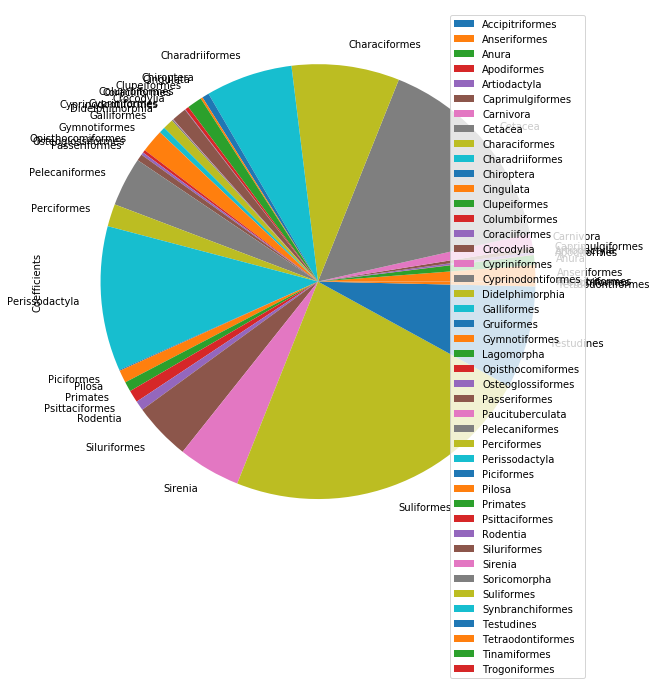

In [180]:
index_of_coefficients =np.argsort(similarity_rfr_df.Coefficients["OTU"])
meancoefficients =np.array(similarity_rfr_df.Coefficients["OTU"]).mean(axis =0)
taxadf["Coefficients"] = meancoefficients
sum_per_class =taxadf.groupby(by = "Order").mean().sum()
(taxadf.groupby(by = "Order").mean()/sum_per_class).plot.pie(y = "Coefficients",figsize =(10,10))

In [268]:
#dataframe = diffsimilarity_rfr_df
def scaledtaxamethod(dataframe,taxon_level="Order",taxa = taxadf,index = ["OTU","OTU CSS","OTU MIN CSS","OTU CSS LOG"]):
    """
    Input
    dataframe: Dataframe from runningsplittest method
    """
    #taxon_level = "Order"
    taxa_dataf = taxa.copy()
    # get index of dataframe
    index = dataframe.index
    for i in index:
        mean_of_folds =np.abs(np.array(dataframe.Coefficients[i])).mean(axis =0)
        print(mean_of_folds.shape)
        taxa_dataf[i] = mean_of_folds
    # To change aggregate change the mean taxa by level. If its set to sum then it sums, if mean then the average is found
    mean_taxa_by_level = taxa_dataf.groupby(by=taxon_level).sum()
    scaled_taxa_by_level =mean_taxa_by_level/mean_taxa_by_level.sum()
    return(scaled_taxa_by_level)

In [244]:
%matplotlib inline
def func(pct):
    if pct >=5:
        return "{:.1f}%".format(pct)
    else:
        return("")
def pieplots(scaled_taxa,ax_titles,filenameprefix):
    shape_of_df = scaled_taxa.shape
    colord =20
    scaled_taxa_by_level_color = np.arange(0,shape_of_df[0])%colord
    col_to_plot =scaled_taxa.columns
    #ax_titles = ["Similarity OTU","Similarity OTU CSS", "Similarity OTU MIN CSS","Dissimilarity OTU","Dissimilarity OTU CSS", "Dissimilarity OTU MIN CSS"]
    #fig,axes = plt.subplots(nrows = 3,ncols=2,figsize=(20,30))
    
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0,1,colord)]
    plt.rcParams.update({'font.size': 20})

    #axes.set_color_cycle(colors)
    for i,j in enumerate(col_to_plot):
        print(j)
        #ax = axes[i%3,i//3]
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes()
        sortedindx = np.argsort(scaled_taxa[j])
        sortedcolor = [colors[k] for k in scaled_taxa_by_level_color[sortedindx]]
        sortedlabels =scaled_taxa.index[sortedindx].values
        sortedlabels[0:-6] =""
        ax.pie(x = scaled_taxa[j][sortedindx],labels=sortedlabels,colors=sortedcolor,startangle=30, autopct=lambda pct: func(pct))
        ax.set_title(ax_titles[i],fontsize = 20)
        fig.savefig(fname=filenameprefix+j+".png",transparent=True,dpi=300)
        #scaled_taxa_by_level.plot.pie(y=i,legend =False,figsize=(10,10))
    #fig.suptitle(figure_title,fontsize=22,y=0.93)   
    #fig.subplots_adjust(wspace=0.01)
    #fig.savefig(figure_name,transparent=True,dpi = 300)

(375,)
(375,)
(375,)
Fish
Fish CSS
Fish CSS LOG


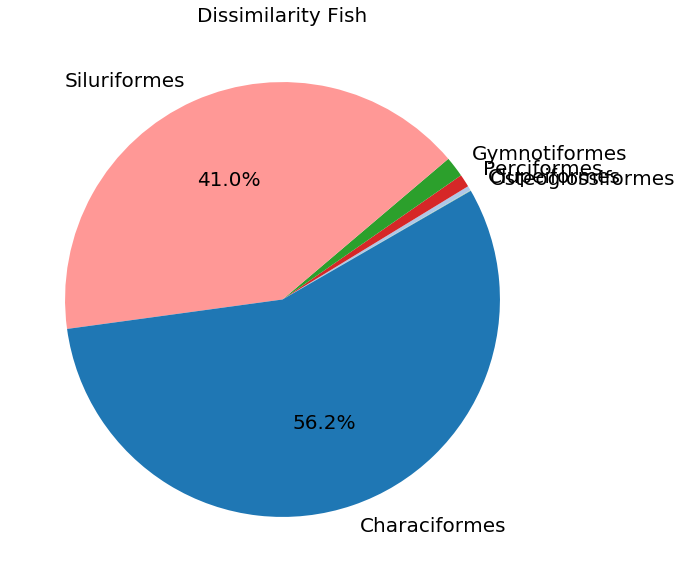

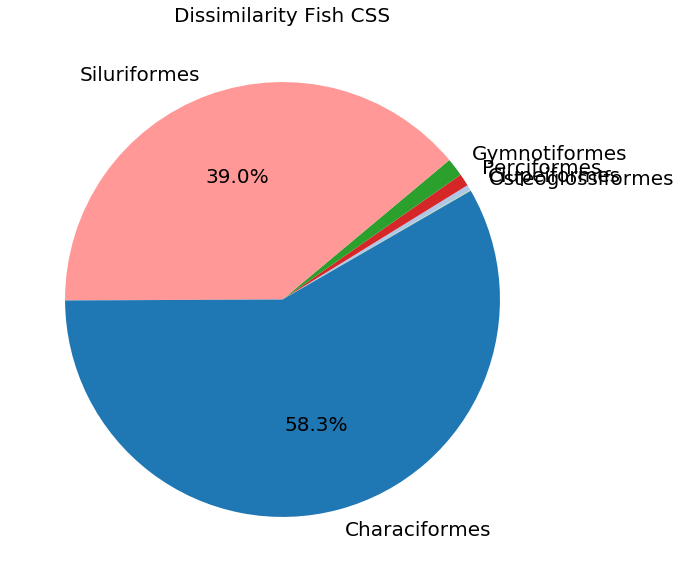

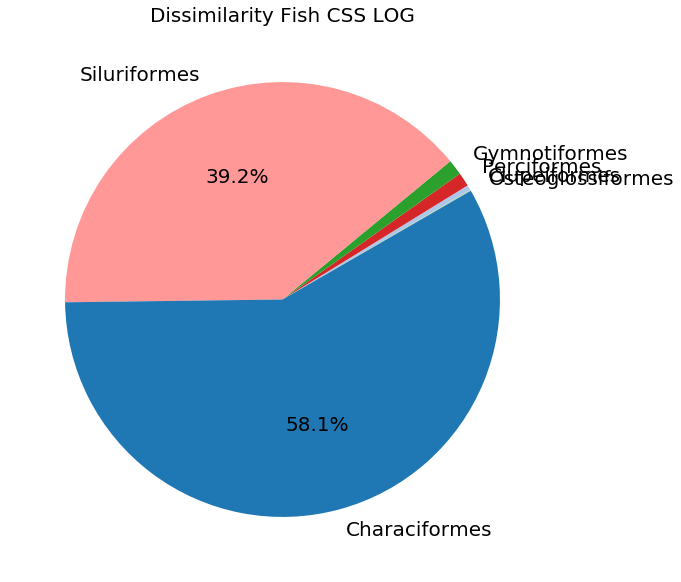

In [269]:
col_to_plot = ["Dissimilarity Fish","Dissimilarity Fish CSS",
               "Dissimilarity Fish CSS LOG"]
#scaledtaxamethod(dissim_rfr_df)
pieplots(scaledtaxamethod(dis_rfr_fish,taxa=taxadf.loc[fishdf.columns]),col_to_plot,"rfr_dis_fish_sum_pie")

In [197]:
sim_log_df

,Scores,Parameters,Coefficients,Confusion
OTU,"[1.0, 0.9615384615384616, 0.96, 1.0, 0.9545454...","[{'C': 12.000999999999998, 'class_weight': 'ba...","[[[0.0, -0.0002198539667407331, 0.0, 0.0, 0.0,...","[[19.0, 2.0], [1.0, 142.0]]"
OTU CSS,"[1.0, 0.9615384615384616, 0.96, 1.0, 1.0, 0.95...","[{'C': 11.000999999999998, 'class_weight': 'ba...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0022487038598083...","[[18.0, 3.0], [0.0, 143.0]]"
OTU MIN CSS,"[1.0, 0.96, 0.9583333333333334, 1.0, 1.0, 0.95...","[{'C': 14.000999999999998, 'class_weight': 'ba...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0028652730675881...","[[18.0, 3.0], [0.0, 136.0]]"
PCoA,"[0.9230769230769231, 1.0, 0.92, 0.916666666666...","[{'C': 5.0009999999999994, 'class_weight': 'ba...","[[[2.92331113354231, 0.2777456354398347, 6.575...","[[16.0, 5.0], [3.0, 140.0]]"
PCoA CSS,"[1.0, 1.0, 0.96, 0.9166666666666666, 0.9545454...","[{'C': 7.0009999999999994, 'class_weight': Non...","[[[0.0, 0.4520290194392362, 11.822750165227902...","[[16.0, 5.0], [1.0, 142.0]]"
OTU CSS LOG,"[0.9615384615384616, 0.9615384615384616, 0.96,...","[{'C': 13.000999999999998, 'class_weight': 'ba...","[[[0.0, 0.0, -0.000306023954884166, 0.0, 0.0, ...","[[19.0, 2.0], [1.0, 142.0]]"
OTU LOW COR,"[1.0, 0.9615384615384616, 0.96, 1.0, 1.0, 1.0,...","[{'C': 19.000999999999998, 'class_weight': 'ba...","[[[0.0, -0.0017936967208004042, -0.00160127463...","[[19.0, 2.0], [0.0, 143.0]]"
PCoA 99%,"[0.9230769230769231, 1.0, 0.92, 0.916666666666...","[{'C': 5.0009999999999994, 'class_weight': 'ba...","[[[2.9232119843650226, 0.2779139724815713, 6.5...","[[16.0, 5.0], [3.0, 140.0]]"
PCoA 90%,"[0.9230769230769231, 1.0, 0.92, 0.916666666666...","[{'C': 5.0009999999999994, 'class_weight': 'ba...","[[[2.9233318634368213, 0.2776209160762664, 6.5...","[[16.0, 5.0], [3.0, 140.0]]"
PCoA CSS 99%,"[1.0, 1.0, 0.96, 0.9166666666666666, 0.9545454...","[{'C': 7.0009999999999994, 'class_weight': Non...","[[[0.0, 0.45185115653113256, 11.82275297680998...","[[16.0, 5.0], [1.0, 142.0]]"


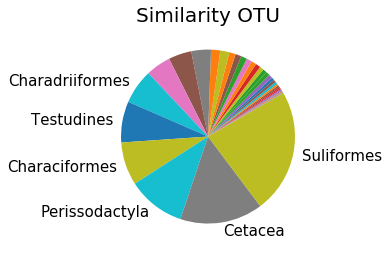

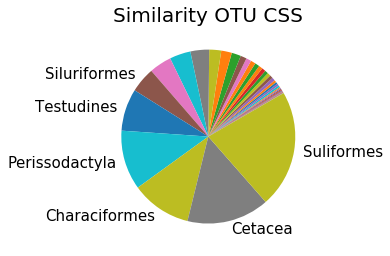

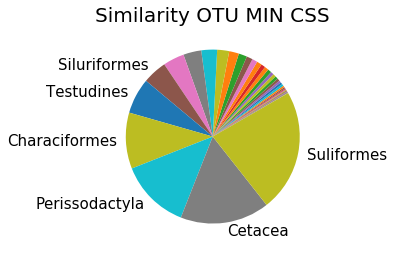

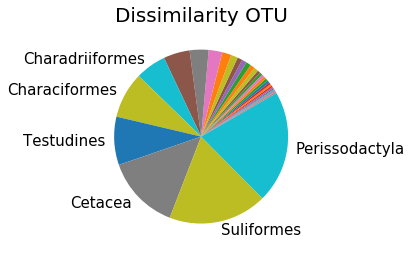

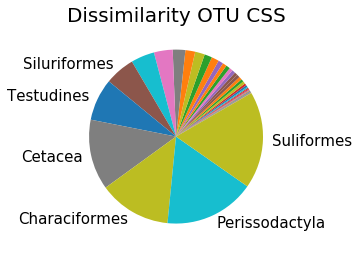

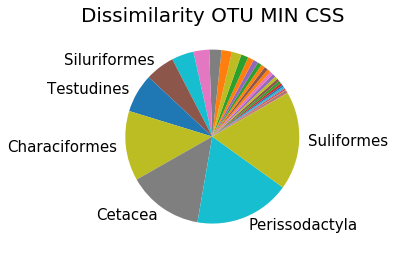

In [406]:
col_to_plot=["Similarity OTU","Similarity OTU CSS","Similarity OTU MIN CSS"]
pieplots(scaled_taxa_by_level,None,"rfr_order_pie")

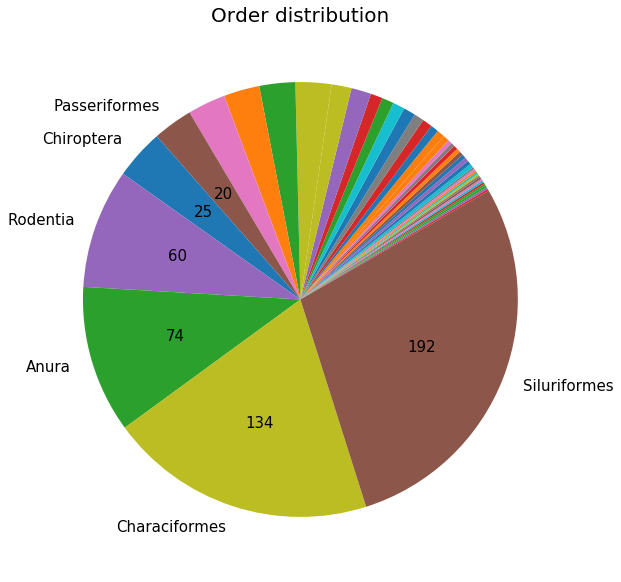

In [115]:
scaled_taxa = taxadf.groupby("Order").count()
shape_of_df = scaled_taxa.shape
scaled_taxa_by_level_color = np.arange(0,shape_of_df[0])%10
col_to_plot =[scaled_taxa.columns[0]]
#ax_titles = ["Similarity OTU","Similarity OTU CSS", "Similarity OTU MIN CSS","Dissimilarity OTU","Dissimilarity OTU CSS", "Dissimilarity OTU MIN CSS"]
#fig,axes = plt.subplots(nrows = 3,ncols=2,figsize=(20,30))

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0,1,10)]
plt.rcParams.update({'font.size': 15})

#axes.set_color_cycle(colors)
for i,j in enumerate(col_to_plot):
    #ax = axes[i%3,i//3]
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    sortedindx = np.argsort(scaled_taxa[j])
    sortedcolor = [colors[k] for k in scaled_taxa_by_level_color[sortedindx]]
    sortedlabels =scaled_taxa.index[sortedindx].values
    sortedlabels[0:-6] =""
    ax.pie(x = scaled_taxa[j][sortedindx],labels=sortedlabels,colors=sortedcolor,startangle=30
          ,autopct=lambda p:  '{:.0f}'.format(p * 675 / 100) if p >= 2.90 else "")
    ax.set_title("Order distribution",fontsize = 20)
    fig.savefig(fname="orderdistrpie.png",transparent=True,dpi=300)